## Exploration 4. 인공지능으로 세상에 없던 새로운 패션 만들기

# Project 'CIFAR-10 이미지 생성하기'

**[프로젝트 목표]**
- DCGAN 모델 구조를 이용해서 CIFAR-10 데이터를 생성하는 모델 구현

**[진행과정]**
1. 작업환경 구성
2. 데이터셋 구성
3. 생성자 모델 구현
4. 판별자 모델 구현
5. 손실함수, 최적화 함수 구현
6. 훈련과정 상세 기능 구현
7. 학습 과정 진행
8. GAN 훈련 과정 개선


[Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
The tips draw upon the suggestions from the DCGAN paper as well as elsewhere.
A summary of some of the more actionable tips is provided below.

- Normalize inputs to the range [-1, 1] and use tanh in the generator output.
- Flip the labels and loss function when training the generator.
- Sample Gaussian random numbers as input to the generator.
- Use mini batches of all real or all fake for calculating batch norm statistics.
- Use Leaky ReLU in the generator and discriminator.
- Use Average pooling and stride for downsampling; use ConvTranspose2D and stride for upsampling.
- Use label smoothing in the discriminator, with small random noise.
- Add random noise to the labels in the discriminator.
- Use DCGAN architecture, unless you have a good reason not to.
- A loss of 0.0 in the discriminator is a failure mode.
- If loss of the generator steadily decreases, it is likely fooling the discriminator with garbage images.
- Use labels if you have them.
- Add noise to inputs to the discriminator and decay the noise over time.
- Use dropout of 50 percent during train and generation.

# Step1. 작업환경 구성

In [1]:
# # prepare folders for dataset, training
# !mkdir -p /aiffel/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/generated_samples
# !mkdir -p /aiffel/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/training_checkpoints
# !mkdir -p /aiffel/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/training_history

In [2]:
# # To generate GIFs
# !pip install imageio

In [3]:
# import library
import os
import glob
import time
import imageio
import PIL
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

print('tensorflow', tf.__version__)

tensorflow 2.6.0


# Step2. 데이터셋 구성

## Load data

- CIFAR-10 데이터셋 활용
- 분류문제에서 사용했던 label이 필요 없음 -> `_(underscore)`로 해당 데이터(`y_train`, `y_test`)는 사용x

In [4]:
# use cifar10 dataset
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [5]:
print('max pixel:', train_x.max())
print('min pixel:', train_x.min())

max pixel: 255
min pixel: 0


In [6]:
# pixel normalization
train_x = (train_x - 127.5) / 127.5 # Normalize the images to [-1, 1]

print('max pixel:', train_x.max())
print('min pixel:', train_x.min())

max pixel: 1.0
min pixel: -1.0


In [7]:
# check shape
train_x.shape

(50000, 32, 32, 3)

In [8]:
train_x.dtype

dtype('float64')

- float64는 메모리를 더 많이 차지하고, 32bit floating point number보다 연산속도가 느림
    - float32로 수정해서 사용

In [9]:
# data type 변경 
train_x = train_x.astype('float32')
train_x.shape, train_x.dtype

((50000, 32, 32, 3), dtype('float32'))

In [10]:
# check test dataset
test_x.shape

(10000, 32, 32, 3)

- train dataset : 50,000
- test dataset : 10,000
- 이미지 사이즈 : 32x32
- 컬러이미지

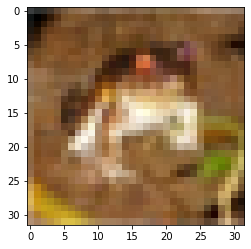

In [11]:
# visualize image
plt.imshow((train_x[0]+ 1) / 2) # Rescale values to [0, 1]
plt.show() 

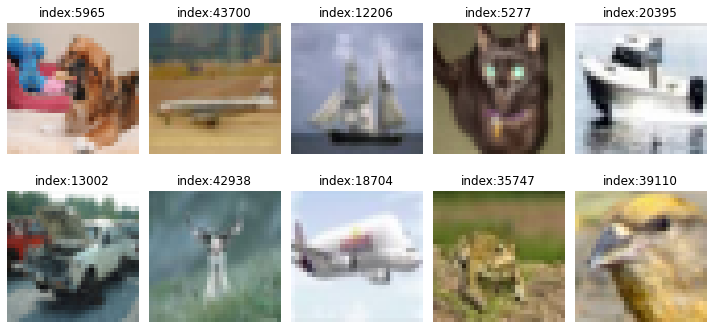

In [12]:
# visualize random 10 images
import random

plt.figure(figsize=(10,5))

# generate 10 random indices
random_indices = random.sample(range(len(train_x)), 10)

for i, index in enumerate(random_indices):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[index] + 1) / 2) # Rescale values to [0, 1]
    plt.title(f'index:{index}')
    plt.axis('off') # Optional: Turn off axis labels for better visualization
    
plt.tight_layout()
plt.show()

## tf.Dataset 미니배치 사용
- 데이터가 잘 섞이게 하려면 BUFFER_SIZE를 총 데이터사이즈와 같게 하거나 크게 설정!
- 배치사이즈는 100으로 설정
    - [논문](https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf)에서 사용했던 코드를 보니 기본값을 100으로 설정하고 매번 따로 입력받는 형식으로 한것 같다

In [13]:
# use tf.Dataset
BUFFER_SIZE = 50000  # to shuffle whole dataset : 50000
BATCH_SIZE = 100

In [14]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Model - DCGAN

- Deep Convolutional Generative Adversarial Network

---

## 💡 [GAN Generative Adversarial Network](https://arxiv.org/pdf/1406.2661.pdf)
- 생성 모델
- network : 
    - **Generator 생성자** : random noise에서 이미지 형상의 벡터를 생성
    - **Discriminator 판별자** : 기존의 진짜 이미지와 생성자가 만든 이미지를 입력받아 실제여부를 판단-실수값으로 출력
- 2개의 네트워크가 서로 경쟁하며 파라미터를 조정해서 더 구별하기 어려운 이미지가 생성되는 방식
    
**[REF]** [OpenAI-Generative models](https://openai.com/research/generative-models)

---

# Creat the models
**[REF]** [tf tutorial](https://www.tensorflow.org/tutorials/generative/dcgan)

💡 [Improved Techniques for Training GANs(paper)](https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf)
> CIFAR-10 is a small, well studied dataset of 32 × 32 natural images.<br> We use this data set to study semi-supervised learning, as well as to examine the visual quality of samples that can be achieved.<br>
For the **discriminator** in our GAN we **use a 9 layer deep convolutional network with dropout and weight normalization**. <br>**The generator is a 4 layer deep CNN with batch normalization**

# Step 3. Generator 모델 구현

## The Generator
The generator uses [`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) (upsampling) layers to produce an image from a seed (random noise). 

- Start with a Dense layer that takes this seed as input
- then upsample several times until you reach the **desired image size of 32x32x3**
- Notice the **[`tf.keras.layers.LeakyReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) activation for each layer**, except **the output layer which uses tanh**.


- `Conv2DTranspose`는 일반적인 `Conv2D`와 반대로 이미지 사이즈를 넓혀줌 ([transposed convolution](https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11))
- `Conv2DTranspose` 3번 진행 : 위 논문을 참고해서 `(4, 4, 512) → (8, 8, 256) → (16, 16, 128) → (32, 32, 3)` 순으로 준비한 데이터셋과 동일한 사이즈까지 이미지를 키워감

In [15]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 512)))
    assert model.output_shape == (None, 4, 4, 512)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

In [16]:
# check generator
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              819200    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0

## Generator로 random noise 생성
- tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있다

In [17]:
# random noise vector
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False) # 지금은 trianing이 아니기때문에 'training=False'로 지정
generated_image.shape 

TensorShape([1, 32, 32, 3])

batch_size=1인 (32, 32, 3)shape의 이미지가 생성됨

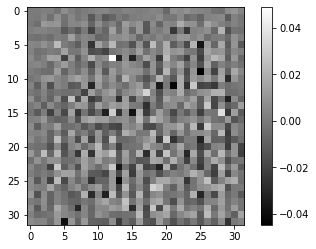

In [18]:
# Visualize random noise
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

# ✅ color로 시각화하는 코드로 수정

In [ ]:
# # Visualize random noise - color 
# plt.imshow(generated_image * 127.5 + 127.5)
# plt.show()

# Step 5. Discriminator 모델 구현

## The Discriminator
- CNN-based image classifier
> For the discriminator in our GAN we use a **9 layer deep convolutional network with dropout and weight normalization**
    - [논문](https://proceedings.neurips.cc/paper_files/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf)에서는 discriminator에서 **Weight normalization 가중치정규화**도 진행했다고 하는데, 일단 model 구조만 참고해서 구현하고, 성능개선할 시간이 생기면 그때 이 부분에 대해 찾아보고 시도해보려고한다

In [19]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    # layer 1
    ### set stride 2 for final layer only
    model.add(layers.Conv2D(96, (3, 3), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(96, (3, 3), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(96, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.Dropout(0.5)) # 50% dropout

    # layer 2
    ### set stride 2 for final layer only
    model.add(layers.Conv2D(192, (3, 3), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(192, (3, 3), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(192, (3, 3), strides=(2, 2), padding='same'))    
    model.add(layers.Dropout(0.5)) # 50% dropout

    # layer 3
    model.add(layers.Conv2D(192, (3, 3), padding='valid')) # valid padding
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(192))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(192))
    model.add(layers.LeakyReLU())
    model.add(layers.GlobalAveragePooling2D()) # Using global average pooling instead of Flatten

    # layer 4
    ### node 1 : goal is to have a binary output => whether the input is real or fake
    model.add(layers.Dense(1, activation='linear')) # Default activation for Dense is linear
              
    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. 
- The model will be trained to output positive values for real images, and negative values for fake images.

In [20]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[2.3942048e-05]], shape=(1, 1), dtype=float32)


- decision 값이 0에 가까우면 fake **=> 결과값 : 아직은 fake**
- decision 값이 1에 가까우면 real 로 간주


# Step 5. 손실함수, 최적화 구현 : Define the loss, optimizer

## Loss function - cross entropy
- GAN은 loss funciton으로 교차 엔트로피를 사용(Cross Entropy)
    - 두 확률 분포의 차이를 구할때 사용
- Discriminator는 한 개의 이미지를 가짜(0)인지 진짜(1)인지 판별 -> 이진분류 : binary cross entropy 사용

- `BinaryCrossEntropy` : input은 0 - 1 사이의 확률값이라고 가정 -> `from_logits=True`로 설정해야함
> When from_logits=True, the model's output is considered a logit.<br> **A logit is a raw, unnormalized prediction score** that can range from negative infinity to positive infinity.<br> It **hasn't undergone the final activation function** (e.g., softmax) that would convert it into a probability.<br>
The logit values are useful during the training phase, especially when using loss functions that work directly with logits. This allows for more numerical stability during optimization.

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

**[이미지 label]**
- real img : label 1
- fake img : label 0


**cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output**
- fake_output : generator(생성자)가 생성한 Fake Image를 discriminator(구분자)에 입력시켜서 판별된 값 = D(fake_image) 
- real_output : 기존에 있던 Real Image를 discriminator(구분자)에 입력시켜서 판별된 값 = D(real_image) 


**loss 계산을 위해 `tf.zeros_like()`, `tf.ones_like()`사용**
- output shape과 동일한 0 / 1로 채워진 tensor를 만들어서 cross-entropy 비교할때 사용

## generator_loss
generator_loss는 **fake_output이 1**에 가까워지는게 목표 => 잘되면 loss 값은 0에 가까워짐
- tf.ones_like와의 교차 엔트로피값을 계산  
- `cross_entropy(tf.ones_like(fake_output), fake_output)` 값은 
    - fake_output이 1(Real Image를 의미)에 가까울수록 **작은 값**을 가짐

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## discriminator_loss
discriminator_loss는 **real_output은 1**에 가까워지기를, **fake_output은 0**에 가까워지는게 목표

- 최종 discriminator_loss 값은 이 둘을 더한 값 => 이 loss 값을 최소화해야함! => 0으로 되면 안되고, loss 값은 0.5에 가까워야함?

In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss
    return total_loss

## discriminator accuracy
discriminator가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산하는것도 GAN의 학습에서 매우 중요!
- 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용


- discriminator가 **real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별**해낸다면?
    - generator가 만들어내는 **fake output이 real output과 차이가 많이 나기 때문**에 판별자가 매우 쉽게 판별해 내고 있다는 뜻
    
    
- real accuracy와 fake accuracy는 **초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적**
    - fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 의미

In [24]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

위 함수 안에 사용된 tensorflow 함수들의 역할을 정리하면,

ex. real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,

1. tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
> \>> tf.Tensor([False, False, True, True])


2. tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
> \>> tf.Tensor([0.0, 0.0, 1.0, 1.0])


3. tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
> \>> 0.5


## Optimizer Adam
첫번째 학습에서는 `learning rate=0.0001`로 설정
- 이후에 값 조정


**중요한 점! generator, discriminator 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다!**

In [25]:
# set each optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## random seed
매번 학습이 어떻게 진행되어가고 있는지, 생성자가 생성한 샘플을 확인

- 샘플은 한 번에 16장을 생성
- 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있음 => 고정된 seed로 노이즈 생성
- 즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터 준비

In [26]:
# make noise sample with random seed
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

---

# Step 6. 훈련과정 상세 기능 구현

# Define the training loop
하나의 미니 배치당 진행할 `train_step` 함수 준비
- `@tf.function` 데코레이터 사용
> **tf.function** : Compiles a function into a callable **TensorFlow graph**


---

💡
**[Tensorflow graph](https://www.tensorflow.org/api_docs/python/tf/Graph)**  
: Graph defines **the flow of data through the operations in a TensorFlow model**
- A TensorFlow computation, represented as a dataflow graph.

Graphs are data structures that contain 
- a set of tf.Operation objects, which represent units of computation
- tf.Tensor objects, which represent the units of data that flow between operations. 

=> In short, **graphs** are extremely useful and let your TensorFlow **run fast**, **run in parallel**, and **run efficiently on multiple devices**

*🤓 무슨 말인지 잘 이해가 안가지만,*
*tf.function을 사용하면 tensorflow가 빠르고, 병렬로, 다중처리를 할수 있도록 해준다고한다*

---

[REF] [blog - python decorator](https://schoolofweb.net/blog/posts/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%8D%B0%EC%BD%94%EB%A0%88%EC%9D%B4%ED%84%B0-decorator/), [tensorflow tutorial](https://www.tensorflow.org/api_docs/python/tf/function), [tf doc - graph & tf.funcion](https://www.tensorflow.org/guide/intro_to_graphs)

---

## `train_step` function

**train_step 함수 구성**

- (1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
- (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
- (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
- (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
- (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
- (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
- (7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
- (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
- (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

---

💡 `tf.GradientTape`
- a crucial component in TensorFlow for **automatic differentiation**, a technique used in training machine learning models


1. Context Management:
You use `with tf.GradientTape() as tape`: to define a context where operations are recorded for automatic differentiation.
2. Record Operations:
Inside the `with` block, **any operations involving TensorFlow variables are recorded by the tape**
3. Calculate Gradients:
After executing the operations, you can calculate gradients of a target tensor with respect to some source tensors
4. Automatic Differentiation:
TensorFlow **uses the recorded operations to automatically compute gradients using the backpropagation algorithm**

*🤓 역시 무슨말인지 모르겠지만 tf.GradientTape는 자동미분을 할수 있게 해준다고한다*

In [27]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

## 학습현황 시각화 함수 - `generate_and_save_images`
train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수
- 아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있다
    - 16개이므로 4행 4열로 나누어 subplot(4, 4, i+1)로 시각화
    - plt에 저장되어 보이는 이미지를 plt.savefig로 간단히 파일로 저장

# ✅ `plt.imshow(prediction[i] + 1) / 2)` 로 수정해서 컬러로 출력되도록 조정!<br>
✅ 이미지 크기 조금 더 크게 조정해보기

<!-- 승환님이 알려준 srt관련 에러 : plt.axis('off') 주석처리!
        
#     for i in range(predictions.shape[0]):
#         plt.subplot(4, 4, i+1)
#         img = predictions[i].numpy()
#         img = (img* 127.5) + 127.5
#         img = img.astype(int)
#         plt.imshow(img)
#         plt.axis('off') -->

In [37]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i]*127.5 + 127.5) # reverse of normalization
        plt.axis('off')
   
    plt.savefig('{}/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

## accuracy, history 시각화 함수 - `draw_train_history`
loss와 accuracy 그래프 시각화는 학습 과정을 체크하기 위해 매우 중요!
- train_step() 함수가 리턴하는 `gen_loss`, `disc_loss`, `real_accuracy`, `fake_accuracy` 이상 4가지 값을 **history라는 dict 구조에 리스트로 저장**해두고 
- **매 epoch마다 시각화**
    - 예를 들어 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리

In [38]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  

    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장
    plt.savefig('{}/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

## checkpoint - `training_checkpoint`
`tf.train.Checkpoint`로 버전관리
- epoch마다 모델 저장
- checkpoint : optimizer와 generator, discriminator(정확히는 생성자와 판별자가 학습한 모델 가중치) 저장

In [39]:
checkpoint_dir = os.getenv('HOME')+'aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Step 7. 학습 과정 진행

# Train the model 

**`train` 함수** : 필요한 함수들 모두 결합
- train_step() : 한 단계 학습
- generate_and_save_images() : 샘플 이미지를 생성하고 저장
- draw_train_history() : 학습 과정을 시각화
- checkpoint : 학습 과정을 시각화

=> 학습과정의 loss, accuracy 그래프 이미지 파일이 ../dcgan_newimage/cifar10/training_history 경로에 생성됨 : 진행 과정을 수시확인해보자

In [40]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [32]:
# set epoch
save_every = 5
EPOCHS = 50 

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [33]:
# train

%%time
train(train_dataset, EPOCHS, save_every)

UsageError: Line magic function `%%time` not found.


- cell magic 은 코드셀 첫줄에 나와야한다!

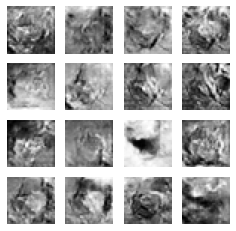

Time for training : 3634 sec


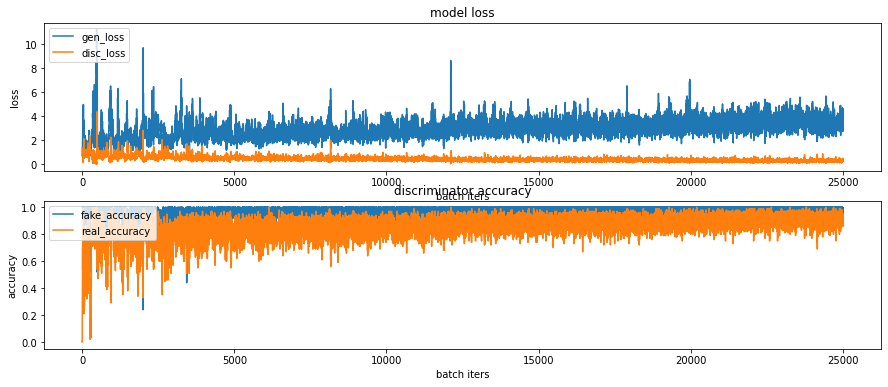

CPU times: user 19min 25s, sys: 2min 41s, total: 22min 7s
Wall time: 1h 36s


In [42]:
%%time

# train
train(train_dataset, EPOCHS, save_every)

- 만약 생성자가 만든 Fake Image에 대한 판별자의 Accuracy(fake_accuracy)가 계속 1에 가깝게 유지되고 있다면, 
    - 생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다는 의미

- 결과물이 아직 흐릿하면 더 많은 epoch으로 학습을 시키거나 모델구조/학습방법 변경



# 학습과정 시각화
학습이 끝난 후 생성했던 샘플 이미지들을 합쳐 GIF 파일(일명 움짤) 생성

- imageio 라이브러리를 활용
    - imageio.get_writer를 활용해서 파일을 열고, 거기에 append_data로 이미지를 하나씩 붙여나가는 방식

In [46]:
anim_file = os.getenv('HOME')+'/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 2048966 Jan 23 07:33 /aiffel/aiffel/workplace/EXPLORATION/Ex04/dcgan_newimage/cifar10/cifar10_dcgan.gif


### 지금까지 만들어진 이미지 gif
<img src='./dcgan_newimage/cifar10/cifar10_dcgan.gif'>


### history 저장된 이미지 비교
1.EPOCH 1 <img src='./dcgan_newimage/cifar10/training_history/train_history_0000.png'>
2.EPOCH 3 <img src='./dcgan_newimage/cifar10/training_history/train_history_0002.png'>
3.EPOCH 7 <img src='./dcgan_newimage/cifar10/training_history/train_history_0006.png'>
4.EPOCH 15 <img src='./dcgan_newimage/cifar10/training_history/train_history_0014.png'>
5.EPOCH 25 <img src='./dcgan_newimage/cifar10/training_history/train_history_0024.png'>
6.EPOCH 35 <img src='./dcgan_newimage/cifar10/training_history/train_history_0034.png'>
7.EPOCH 45 <img src='./dcgan_newimage/cifar10/training_history/train_history_0044.png'>

=> 에포크 15 이후부터는 거의 비슷한 양상의 그래프가 기록되었다.

---

# Summary

- GAN에 대한 전반 이해가 부족해서 나온 결과물이 어떤 의미를 갖는지 해석하는게 어려웠음
- checkpoint에서 이미지 저장을 흑백으로 하는 바람에 최종 저장된 이미지가 흑백으로 만들어짐
- 어쨌든 완성된 gif 이미지를 보면 제대로 이미지가 생성되지 못했다는건 알수 있음
- 아이펠 학습시간 이후에 다시 코드를 수정해서 시도가 필요함

---

# KPT

**[KEEP]**
- 사소한 에러는 일단 해결해가며 코드를 완성했다.

**[PROBLEM]**
- GAN 이론 전반에 대한 이해가 부족하다. 특히 loss값, 정확도 관련해서 어떤 방식으로 값이 산출되는지, 블로그의 개념설명에 매치하면서 이해하기가 어려웠다.
- 컬러 이미지를 출력해야하는데 흑백이미지로 이미지를 저장하는바람에 결과물이 흑백이다.


**[TRY]**
- GAN을 구성하는 여러 개념(cross entropy, loss값 해석 관련, GAN 이론)을 하나씩 차근차근 정리하고 다시 모델을 구현해본다.

---

# ✅ 여기서부터는 아이펠 일과 이후 시간에 진행예정


# Step 8. GAN 훈련 과정 개선
